In [1]:
from math import ceil, log

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [84]:
class DBMeta(object):
    
    def __init__(self, T, K, Z, B, E, bpe, N, phi=1):
        self.T = T
        self.K = K
        self.Z = Z
        self.B = B
        self.E = E
        self.bpe = bpe
        self.N = N
        self.phi = phi
        if (K == T - 1):
            self.is_tiering = True
        else:
            self.is_tiering = False
        
    def level(self):
        
        return ceil(log((self.N * self.E / self.B) +1) / log(self.T))
    
    def write_cost(self):
        cost = (self.T - 1) * (1 + self.phi) * self.level()
        if (self.is_tiering):
            cost = cost / (self.T * self.B)
        else:
            cost = cost / (2 * self.B)
            
        return cost
    
    def dost_write_cost(self):
         
        return (1 / self.B) * (((self.T - 1) * (self.level() - 1) / (self.K + 1)) + (self.T - 1) / (self.Z + 1))

In [105]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
    
    fsz = 14
    plt.rc('font', size=fsz)
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def plot_cost_ratio(df):
    is_tiering = True if df.iloc[-1]['K'] == df.iloc[-1]['T'] - 1 else False
    fig, ax1 = plt.subplots()
    
    color = 'black'
    ax1.set_xlabel('Size Ratio (T)')
    ax1.set_ylabel('Avg $\mu$s per Write', color=color)
    ax1.plot(df['T'], df['measured_write_cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    color = 'red'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost', color=color)
    ax2.plot(df['T'], df['dost_write_cost'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    B, E, num_writes = df.iloc[-1][['B', 'E', 'num_writes']]
    title = [
        'Policy: {}'.format('Tiering' if is_tiering else 'Leveling'),
        'Buffer Size: {} MB'.format(B / (1 << 20)),
        'Entry Size: {} KB'.format(E / (1 << 10)),
        'Writes: {}'.format(int(num_writes))
    ]
        
    ax1.set_title('\n'.join(title))
    
    return fig

In [106]:
df = pd.read_csv('../../data/size_ratio_leveling_cost.csv')
df['model_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).write_cost(), axis=1)
df['dost_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).dost_write_cost(), axis=1)
df['level'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).level(), axis=1)
df['measured_write_cost'] = df['write_time'] / df['num_writes']
df

,T,K,Z,B,E,bpe,N,write_time,num_writes,non_empty_read_time,num_non_empty_reads,empty_read_time,num_empty_reads,model_write_cost,dost_write_cost,level,measured_write_cost
0,2,1,1,1048576,1024,5.0,100000,112996,1000,204035,1000,81522,1000,0.000007,0.000003,7,112.996
1,4,1,1,1048576,1024,5.0,100000,447489,1000,131438,1000,30140,1000,0.000011,0.000006,4,447.489
2,6,1,1,1048576,1024,5.0,100000,791432,1000,145799,1000,14085,1000,0.000014,0.000007,3,791.432
3,8,1,1,1048576,1024,5.0,100000,1577747,1000,120112,1000,9431,1000,0.000020,0.000010,3,1577.747
4,10,1,1,1048576,1024,5.0,100000,690389,1000,171911,1000,18090,1000,0.000017,0.000009,2,690.389
5,12,1,1,1048576,1024,5.0,100000,1000192,1000,124409,1000,16337,1000,0.000021,0.000010,2,1000.192
6,16,1,1,1048576,1024,5.0,100000,1318025,1000,157115,1000,15716,1000,0.000029,0.000014,2,1318.025
7,24,1,1,1048576,1024,5.0,100000,3009601,1000,109032,1000,11340,1000,0.000044,0.000022,2,3009.601
8,32,1,1,1048576,1024,5.0,100000,2425598,1000,118639,1000,10911,1000,0.000059,0.000030,2,2425.598
9,50,1,1,1048576,1024,5.0,100000,12213975,1000,114157,1000,16916,1000,0.000093,0.000047,2,12213.975


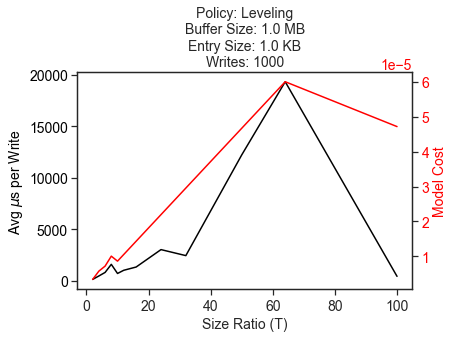

In [107]:
set_style()
fig = plot_cost_ratio(df)

In [88]:
df = pd.read_csv('../../data/size_ratio_tiering_cost.csv')
df['model_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).write_cost(), axis=1)
df['dost_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).dost_write_cost(), axis=1)
df['level'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).level(), axis=1)
df['measured_write_cost'] = df['write_time'] / df['num_writes']
df

,T,K,Z,B,E,bpe,N,write_time,num_writes,non_empty_read_time,num_non_empty_reads,empty_read_time,num_empty_reads,model_write_cost,dost_write_cost,level,measured_write_cost
0,2,1,1,1048576,1024,5.0,100000,111958,1000,191484,1000,69820,1000,0.000007,3.337860e-06,7,111.958
1,3,2,2,1048576,1024,5.0,100000,230556,1000,144546,1000,42416,1000,0.000006,3.178914e-06,5,230.556
2,4,3,3,1048576,1024,5.0,100000,467081,1000,135166,1000,27524,1000,0.000006,2.861023e-06,4,467.081
3,5,4,4,1048576,1024,5.0,100000,763443,1000,167464,1000,16841,1000,0.000005,2.288818e-06,3,763.443
4,6,5,5,1048576,1024,5.0,100000,1070374,1000,128426,1000,11589,1000,0.000005,2.384186e-06,3,1070.374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,95,94,94,1048576,1024,5.0,100000,25190065,1000,113024,1000,10790,1000,0.000004,1.887271e-06,2,25190.065
94,96,95,95,1048576,1024,5.0,100000,25434429,1000,96739,1000,13702,1000,0.000004,1.887480e-06,2,25434.429
95,97,96,96,1048576,1024,5.0,100000,26244504,1000,93413,1000,15096,1000,0.000004,1.887685e-06,2,26244.504
96,98,97,97,1048576,1024,5.0,100000,422286,1000,137798,1000,18548,1000,0.000004,1.887886e-06,2,422.286


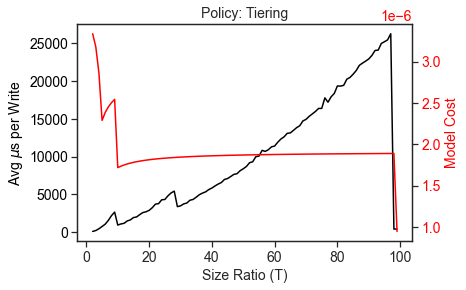

In [93]:
set_style()
fig = plot_cost_ratio(df)

In [95]:
1048576 >> 20

1